# AIR QUALITY

In [35]:
#establish connection
import os
import re
from sagemaker import get_execution_role

#define iam rle

role = get_execution_role()

## SET S3 BUCKET & UPLOAD LOCATION

In [36]:
#specify role and bucket
bucket = 'bucket-name'# s3 bucket where you will copy data and model artifacts
prefix = 'mra/air-quality' # place to upload training files within the bucket

In [37]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import sagemaker
import sagemaker.amazon.common as smac

import warnings
warnings.filterwarnings("ignore")

Data Set Information:

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. 
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded. 

Attribute Information:

#### 0 Date	(DD/MM/YYYY) 
#### 1 Time	(HH.MM.SS) 
#### 2 True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
#### 3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
#### 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
#### 5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
#### 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
#### 7 True hourly averaged NOx concentration in ppb (reference analyzer) 
#### 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
#### 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
#### 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
#### 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
#### 12 Temperature in Â°C	
#### 13 Relative Humidity (%) 
#### 14 AH Absolute Humidity 



##  DATA INGESTION

In [38]:
#download data file as csv
import boto3
import io

s3 = boto3.client('s3')

try:
    obj = s3.get_object(Bucket=bucket, Key='AirQualityUCI.csv')
    #air = pd.read_csv(io.BytesIO(obj['Body'].read()),index_col=0,parse_dates=True,  encoding = "ISO-8859-1")
    air = pd.read_csv(io.BytesIO(obj['Body'].read()),parse_dates=[['Date', 'Time']], encoding = "ISO-8859-1")

    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


In [39]:
#view for full screen
pd.set_option('display.large_repr', 'truncate')
pd.set_option('display.max_columns', 0)


## DATA INSPECTION

In [40]:
# print the shape of the data file
print("Datapoints in data sest",air.shape)

# show the top few rows
display("Top 5 rows",air.head())

Datapoints in data sest (9357, 14)


'Top 5 rows'

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [41]:
# Set Date time as Index
air.set_index('Date_Time', inplace=True)

In [42]:
#nformation of the data
print('\nData Information\n')
air.info()


# statistical description of the data object
display("nStatistical Description of data",air.describe())


Data Information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null int64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null int64
NOx(GT)          9357 non-null int64
PT08.S3(NOx)     9357 non-null int64
NO2(GT)          9357 non-null int64
PT08.S4(NO2)     9357 non-null int64
PT08.S5(O3)      9357 non-null int64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: float64(5), int64(8)
memory usage: 1023.4 KB


'nStatistical Description of data'

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [43]:
air.rename(columns={'T': 'Temparature', 'RH': 'Relative Humidity', 'AH': 'Absolute Humidity'}, inplace=True)
air.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'Temparature', 'Relative Humidity', 'Absolute Humidity'],
      dtype='object')

In [44]:
#check null values
print("Percentage missing data in each column")
pd.isnull(air).sum()

Percentage missing data in each column


CO(GT)               0
PT08.S1(CO)          0
NMHC(GT)             0
C6H6(GT)             0
PT08.S2(NMHC)        0
NOx(GT)              0
PT08.S3(NOx)         0
NO2(GT)              0
PT08.S4(NO2)         0
PT08.S5(O3)          0
Temparature          0
Relative Humidity    0
Absolute Humidity    0
dtype: int64

In [45]:
air = air.replace(-200, np.nan)
print("Percentage missing data in each column \n",pd.isnull(air).sum())

Percentage missing data in each column 
 CO(GT)               1683
PT08.S1(CO)           366
NMHC(GT)             8443
C6H6(GT)              366
PT08.S2(NMHC)         366
NOx(GT)              1639
PT08.S3(NOx)          366
NO2(GT)              1642
PT08.S4(NO2)          366
PT08.S5(O3)           366
Temparature           366
Relative Humidity     366
Absolute Humidity     366
dtype: int64


In [46]:
#replace Null values with Mean

# Mean value of each column
#daf = daf.fillna(0)
print("Mean values to be imputed with:\n",air.mean())

# Use Mean as imputation method for remaining missing data
air = air.fillna(air.mean())
print("\nPercent missing data \n",pd.isnull(air).sum())

Mean values to be imputed with:
 CO(GT)                  2.152750
PT08.S1(CO)          1099.833166
NMHC(GT)              218.811816
C6H6(GT)               10.083105
PT08.S2(NMHC)         939.153376
NOx(GT)               246.896735
PT08.S3(NOx)          835.493605
NO2(GT)               113.091251
PT08.S4(NO2)         1456.264598
PT08.S5(O3)          1022.906128
Temparature            18.317829
Relative Humidity      49.234201
Absolute Humidity       1.025530
dtype: float64

Percent missing data 
 CO(GT)               0
PT08.S1(CO)          0
NMHC(GT)             0
C6H6(GT)             0
PT08.S2(NMHC)        0
NOx(GT)              0
PT08.S3(NOx)         0
NO2(GT)              0
PT08.S4(NO2)         0
PT08.S5(O3)          0
Temparature          0
Relative Humidity    0
Absolute Humidity    0
dtype: int64


In [47]:
air.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Temparature,Relative Humidity,Absolute Humidity
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.316068,212.791672,63.870229,7.302650,261.560236,193.426632,251.743954,43.920954,339.367559,390.612324,8.657639,16.974801,0.395835
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.200000,941.000000,218.811816,4.600000,743.000000,112.000000,666.000000,86.000000,1242.000000,742.000000,12.000000,36.600000,0.746100
50%,2.152750,1075.000000,218.811816,8.600000,923.000000,229.000000,818.000000,113.091251,1456.264598,983.000000,18.300000,49.234201,1.015400
75%,2.600000,1221.000000,218.811816,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


## DATA VISUALIZATION

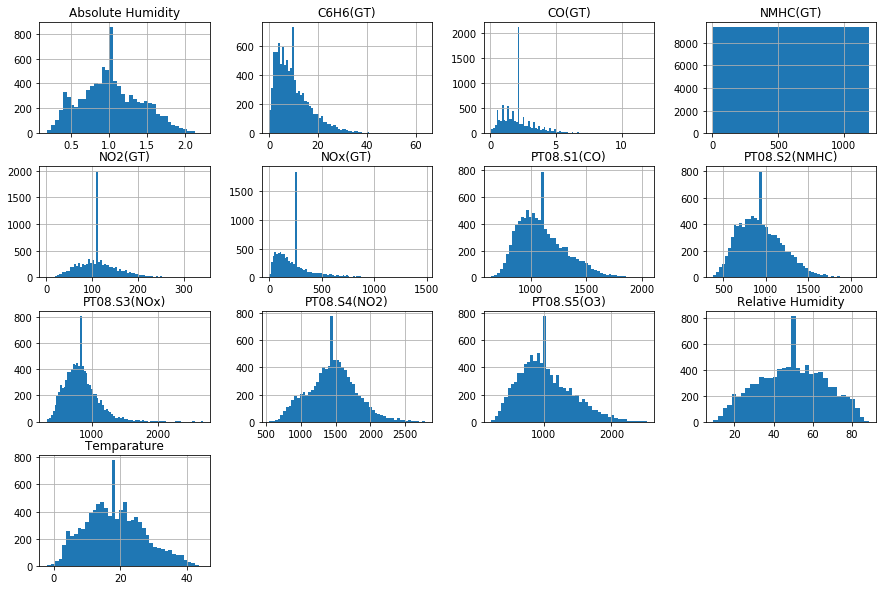

In [48]:
hist = air.hist(bins='auto',  figsize=(15, 10))

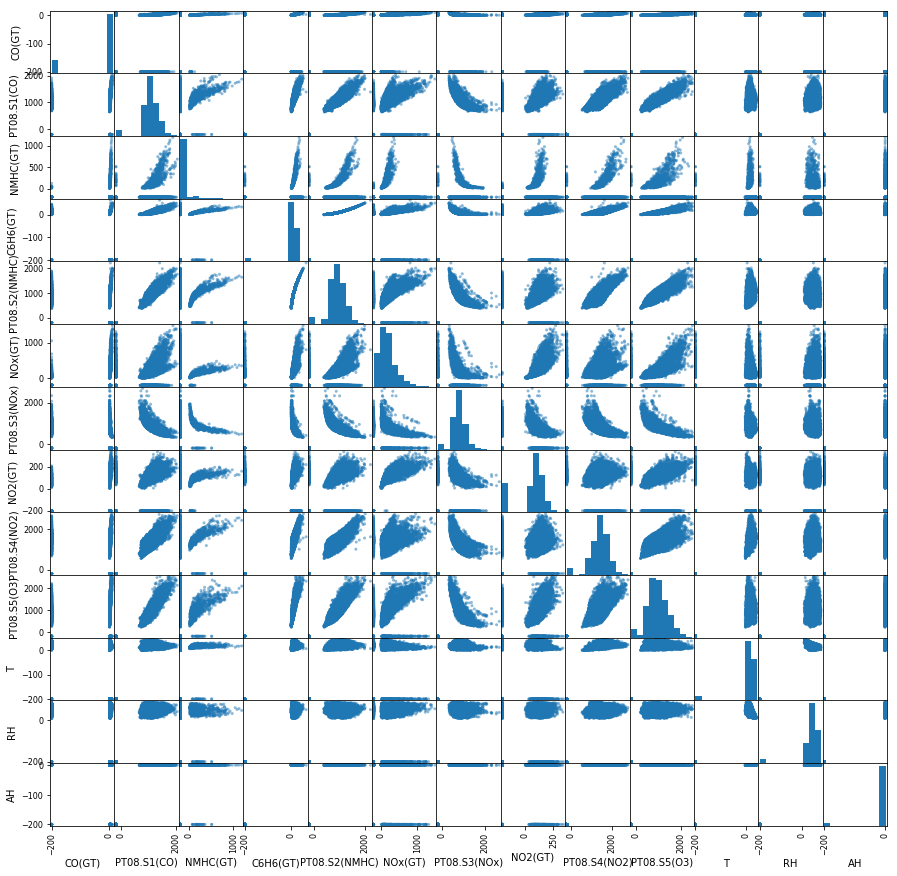

In [21]:
pd.plotting.scatter_matrix(air,figsize=(15, 15))
plt.show()

##  CORRELATION

Text(0.5,1,'Heatmap of Correlation between Features')

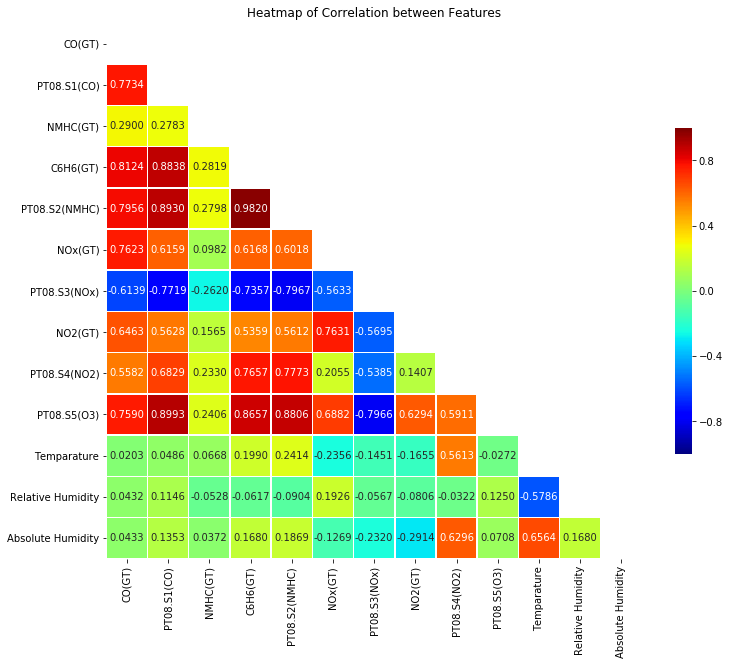

In [49]:
#Correlation of features
import seaborn as sns

corr=air.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))
# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='jet', vmax=1,vmin=-1, center=0,annot=True,fmt= '.4f',
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of Correlation between Features')

## FEATURE SELECTION

### Based on p -value

In [52]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(air_train_X, air_train_y)

print('Resulting Features with p value less than 0.05:')
print(result)

Add  PT08.S4(NO2)                   with p-value 0.0
Add  PT08.S5(O3)                    with p-value 0.0
Add  Relative Humidity              with p-value 0.0
Add  Absolute Humidity              with p-value 0.0
Add  PT08.S2(NMHC)                  with p-value 4.14146e-30
Add  C6H6(GT)                       with p-value 6.062e-30
Add  NO2(GT)                        with p-value 4.81161e-11
Add  CO(GT)                         with p-value 6.29443e-05
Add  NOx(GT)                        with p-value 0.0172162
Resulting Features with p value less than 0.05:
['PT08.S4(NO2)', 'PT08.S5(O3)', 'Relative Humidity', 'Absolute Humidity', 'PT08.S2(NMHC)', 'C6H6(GT)', 'NO2(GT)', 'CO(GT)', 'NOx(GT)']


In [53]:
#mra_X = np.append ( arr = np.ones([152,1]).astype(int), values = mra_X, axis = 1)

## USING OLS

### Feature ranking with recursive feature elimination.

In [54]:
# Using Linear Regression
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)


names =(air_train_X.columns.values)
y = air_train_y.as_matrix()

#use linear regression as the model
lr = LinearRegression()


#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(air_train_X,y)
 
#Results
print("Features sorted by their rank: \n")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))
#print(rfe.ranking_)


Features sorted by their rank: 

[(1, 'Absolute Humidity'), (2, 'Relative Humidity'), (3, 'CO(GT)'), (4, 'C6H6(GT)'), (5, 'PT08.S2(NMHC)'), (6, 'NO2(GT)'), (7, 'PT08.S5(O3)'), (8, 'PT08.S4(NO2)'), (9, 'NOx(GT)'), (10, 'PT08.S1(CO)'), (11, 'NMHC(GT)'), (12, 'PT08.S3(NOx)')]


In [55]:
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False  True]
[ 3 10 11  4  5  9 12  6  8  7  2  1]


# XBOOST GRADIENT DESCENT

In [57]:
# Prefix for Xboost
prefix = 'mra/fit_xboost_auto_hypertune'

In [58]:
air_xgb = air.drop('Temparature',axis = 1)
air_xgb.insert(0,'Temparature', air['Temparature'])

In [59]:
air_xgb.head()


,Temparature,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Relative Humidity,Absolute Humidity
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,13.6,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578
2004-03-10 19:00:00,13.3,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255
2004-03-10 20:00:00,11.9,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502
2004-03-10 21:00:00,11.0,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867
2004-03-10 22:00:00,11.2,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888


In [60]:
# print the shape of the data file
print("Data Dimensions",air_xgb.shape)

# show the top few rows
display(air_xgb.head())

# statistical description of the data object
(air_xgb.describe())

Data Dimensions (9357, 13)


,Temparature,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Relative Humidity,Absolute Humidity
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,13.6,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578
2004-03-10 19:00:00,13.3,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255
2004-03-10 20:00:00,11.9,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502
2004-03-10 21:00:00,11.0,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867
2004-03-10 22:00:00,11.2,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888


,Temparature,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Relative Humidity,Absolute Humidity
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,18.317829,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,49.234201,1.025530
std,8.657639,1.316068,212.791672,63.870229,7.302650,261.560236,193.426632,251.743954,43.920954,339.367559,390.612324,16.974801,0.395835
min,-1.900000,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,9.200000,0.184700
25%,12.000000,1.200000,941.000000,218.811816,4.600000,743.000000,112.000000,666.000000,86.000000,1242.000000,742.000000,36.600000,0.746100
50%,18.300000,2.152750,1075.000000,218.811816,8.600000,923.000000,229.000000,818.000000,113.091251,1456.264598,983.000000,49.234201,1.015400
75%,24.100000,2.600000,1221.000000,218.811816,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,61.900000,1.296200
max,44.600000,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,88.700000,2.231000


### TEST TRAIN SPLIT

In [61]:
# Using 70% as training set
# Using 20% as validation set
#Using 10% as test set

train_data, validation_data, test_data = np.split(air_xgb.sample(frac=1),
                                                  [int(0.7 * len(air_xgb)), int(0.9 * len(air_xgb))])

print('Dimension of train data', train_data.shape)
print('Dimension of train data', validation_data.shape)
print('Dimension of test data', test_data.shape)

Dimension of train data (6549, 13)
Dimension of train data (1872, 13)
Dimension of test data (936, 13)


## CONVERT DATA AS PER XGBOOST FORMAT

In [62]:
# As Xboost Sagemaker does not consider Header and Index
train_data.to_csv('train.csv',sep=',', header=False, index=False)
validation_data.to_csv('validation.csv',sep=',', header=False, index=False)
test_data.to_csv('test.csv',sep=',' , header=False, index=False)

## UPLOAD FILES TO S3

In [63]:
#Copy files to s3 from AWS Sagemaker training to read

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [64]:
# Input and Validation path
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

## TRAIN MODEL

In [65]:
# Set container image
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [66]:
#Xboost algorithm
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

#Set Xboost parameters
xgb.set_hyperparameters(eval_metric= "rmse",
                        objective='reg:linear',
                        num_round=100
                       )
#xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 


## SET PARAMETERS FOR AUTO HYPER PARAMETER TUNING

In [67]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10)}

In [68]:
# Validation metrics
objective_metric_name = 'validation:rmse'


## AUTO HYPERTUNE

In [69]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions=None,
                            objective_type='Minimize',
                            max_jobs=20,
                            max_parallel_jobs=3)



In [70]:
# Fit the model in the auto hypertune
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating hyperparameter tuning job with name: xgboost-181218-0159


## TRACK PROGRESS FOR AUTO HYPERTUNE


In [71]:
#Hypertune Progress
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [72]:
#print(tuning_job_name)
tuner.latest_tuning_job.job_name

'xgboost-181218-0159'

In [73]:
#Track status
tuning_job_name= tuner.latest_tuning_job.job_name
smclient = boto3.Session().client('sagemaker')


# run this cell to check current status of hyperparameter tuning job
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
    job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
    print("%d training jobs have completed" % job_count)

    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

## BEST TRAINING JOB FOR AUTO HYPERTUNE

In [74]:
sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

<sagemaker.HyperparameterTuningJobAnalytics for xgboost-181218-0159>

In [75]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2018, 12, 18, 2, 2, 39, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:rmse',
                                                 'Value': 0.3618850111961365},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2018, 12, 18, 2, 5, 44, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:887931365560:training-job/xgboost-181218-0159-004-9650c1f5',
 'TrainingJobName': 'xgboost-181218-0159-004-9650c1f5',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2018, 12, 18, 2, 5, 3, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.15949246152606913',
                          'eta': '0.08252984517921182',
                          'max_depth': '5',
                          'min_child_weight': '2.4307852047356056'}}


In [76]:
tuner_result = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_result.dataframe()

In [77]:
if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 20
{'lowest': 0.3618850111961365, 'highest': 18.070199966430664}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,eta,max_depth,min_child_weight
16,0.361885,41.0,2018-12-18 02:05:44+00:00,xgboost-181218-0159-004-9650c1f5,Completed,2018-12-18 02:05:03+00:00,0.159492,0.082530,5.0,2.430785
10,0.417215,42.0,2018-12-18 02:12:13+00:00,xgboost-181218-0159-010-6cc2f2f0,Completed,2018-12-18 02:11:31+00:00,0.949226,0.399882,10.0,3.486121
12,0.447457,37.0,2018-12-18 02:09:20+00:00,xgboost-181218-0159-008-4ef77a99,Completed,2018-12-18 02:08:43+00:00,1.645782,0.458487,6.0,1.164984
1,0.454091,43.0,2018-12-18 02:22:04+00:00,xgboost-181218-0159-019-7d70936b,Completed,2018-12-18 02:21:21+00:00,0.956428,0.488810,7.0,9.151221
5,0.522326,38.0,2018-12-18 02:16:19+00:00,xgboost-181218-0159-015-a9c1cb19,Completed,2018-12-18 02:15:41+00:00,0.036262,0.371013,3.0,8.069068
18,0.543939,37.0,2018-12-18 02:02:04+00:00,xgboost-181218-0159-002-6286e3e0,Completed,2018-12-18 02:01:27+00:00,1.906782,0.225889,3.0,2.425215
17,0.575747,42.0,2018-12-18 02:02:11+00:00,xgboost-181218-0159-003-de81dea6,Completed,2018-12-18 02:01:29+00:00,1.970098,0.840126,3.0,7.011593
19,0.583856,43.0,2018-12-18 02:02:39+00:00,xgboost-181218-0159-001-bba41582,Completed,2018-12-18 02:01:56+00:00,0.300647,0.660920,8.0,3.488955
8,0.649777,51.0,2018-12-18 02:12:36+00:00,xgboost-181218-0159-012-7cfef834,Completed,2018-12-18 02:11:45+00:00,0.965889,0.794791,10.0,8.245673
9,0.671266,44.0,2018-12-18 02:13:16+00:00,xgboost-181218-0159-011-0980387a,Completed,2018-12-18 02:12:32+00:00,1.973723,0.767985,10.0,7.212134


In [78]:
tuner_result.tuning_ranges.keys()

dict_keys(['max_depth', 'eta', 'min_child_weight', 'alpha'])

In [81]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner_result)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

In [80]:
ranges = tuner_result.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

## DEPLOY MODEL

In [82]:
xgb_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m5.large')

2018-12-18 02:05:44 Starting - Preparing the instances for training
2018-12-18 02:05:44 Downloading - Downloading input data
2018-12-18 02:05:44 Training - Training image download completed. Training in progress.
2018-12-18 02:05:44 Uploading - Uploading generated training model
2018-12-18 02:05:44 Completed - Training job completedArguments: train
[2018-12-18:02:05:30:INFO] Running standalone xgboost training.
[2018-12-18:02:05:30:INFO] Setting up HPO optimized metric to be : rmse
[2018-12-18:02:05:30:INFO] File size need to be processed in the node: 0.79mb. Available memory size in the node: 8401.84mb
[2018-12-18:02:05:30:INFO] Determined delimiter of CSV input is ','
[02:05:30] S3DistributionType set as FullyReplicated
[02:05:30] 6549x12 matrix with 78588 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-12-18:02:05:30:INFO] Determined delimiter of CSV input is ','
[02:05:30] S3DistributionType set as FullyReplicated
[02:05:30] 1872x12 matrix w

INFO:sagemaker:Creating model with name: xgboost-2018-12-18-02-52-58-649


Billable seconds: 41


INFO:sagemaker:Creating endpoint with name xgboost-181218-0159-004-9650c1f5


--------------------------------------------------------------!

## PREDICTION

In [83]:
from sagemaker.predictor import csv_serializer, json_deserializer


xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [84]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

In [86]:
predictions_test = predict(test_data.as_matrix()[:, 1:])
#predictions_test

In [87]:
predictions_train = predict(train_data.as_matrix()[:, 1:])

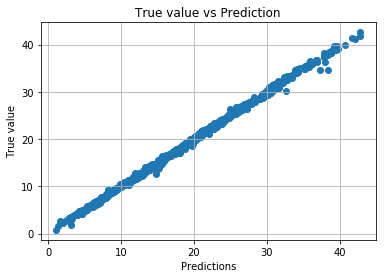

In [89]:
# True values vs Predictions
plt.scatter(test_data['Temparature'], predictions_test)
#plt.scatter(x,y)
plt.xlabel("Predictions")
plt.ylabel("True value")
plt.title("True value vs Prediction")
plt.grid(True)


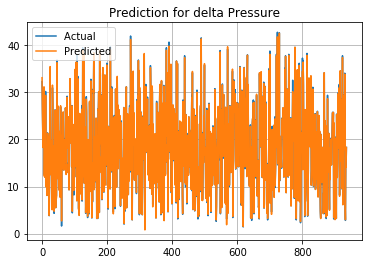

In [90]:
plt.plot(np.array(test_data['Temparature']), label='Actual ')
plt.plot(predictions_test, label='Predicted')
plt.title("Prediction for delta Pressure")
plt.legend()
plt.grid(True)
plt.show()

In [91]:
test_data.shape

(936, 13)

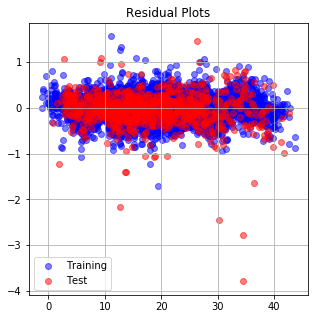

In [97]:
#Residual Plot
f, ax = plt.subplots(figsize=(5, 5))
train_res = plt.scatter(predictions_train,(predictions_train-np.array(train_data['Temparature'])),c='b',alpha=0.5)
test_res = plt.scatter(predictions_test,(predictions_test-np.array(test_data['Temparature'])),c='r',alpha=0.5)
plt.legend((train_res,test_res),('Training','Test'),loc='lower left')
plt.title('Residual Plots')
plt.grid(True)
plt.show()


## STATISTICAL RESULTS

In [100]:
test_mae_linear = np.mean(np.abs(test_data['Temparature'] - predictions_test))
test_mae_baseline = np.mean(np.abs(test_data['Temparature'] - np.median(train_data['Temparature']))) ## training median as baseline predictor

print("TEST RESULTS:\n")
print("Test Mean Absolute Error Baseline :", round(test_mae_baseline, 3))
print("Test Mean Absolute Error Linear:", round(test_mae_linear,3))

#Mean Squared Error
mse =np.mean((np.subtract(test_data['Temparature'], predictions_test))**2)
print("Test Mean Squared Error", mse)

print('One-step-ahead Median Absolute Percentage Error for test date = ',
      np.median(np.abs(np.subtract(test_data['Temparature'], predictions_test))/test_data['Temparature']))

TEST RESULTS:

Test Mean Absolute Error Baseline : 7.252
Test Mean Absolute Error Linear: 0.237
Test Mean Squared Error 0.13117839028791745
One-step-ahead Median Absolute Percentage Error for test date =  0.010156448555555487


In [101]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: xgboost-181218-0159-004-9650c1f5
